In [51]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
import pickle
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn import svm
import timeit
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

# Collect Data from Dataset

In [3]:
def csvToDataset(first, last):
    df = pd.concat((pd.read_csv(f"/kaggle/input/cic-iot-2023/part-{str(index).zfill(5)}-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv")
                     for index in range(first,last)))
    # change column names
    df.columns = ['_'.join(c.split(' ')).lower() for c in df.columns]

    # drop NULLs & reset index
    entries_before = len(df)
    print(f"entries before: {len(df)}")
    df.dropna(inplace=True)
    df.reset_index(inplace=True, drop=True)
    print(f"entries after: {len(df)}")
    print(f"null values in dataframe: {(entries_before - len(df))*100 / entries_before}%")

    return df

df = csvToDataset(0, 50)

df.head()

entries before: 12859545
entries after: 12859545
null values in dataframe: 0.0%


,flow_duration,header_length,protocol_type,duration,rate,srate,drate,fin_flag_number,syn_flag_number,rst_flag_number,...,std,tot_size,iat,number,magnitue,radius,covariance,variance,weight,label
0,0.000000,54.00,6.00,64.00,0.329807,0.329807,0.0,1.0,0.0,1.0,...,0.000000,54.00,8.334383e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS-RSTFINFlood
1,0.000000,57.04,6.33,64.00,4.290556,4.290556,0.0,0.0,0.0,0.0,...,2.822973,57.04,8.292607e+07,9.5,10.464666,4.010353,160.987842,0.05,141.55,DoS-TCP_Flood
2,0.000000,0.00,1.00,64.00,33.396799,33.396799,0.0,0.0,0.0,0.0,...,0.000000,42.00,8.312799e+07,9.5,9.165151,0.000000,0.000000,0.00,141.55,DDoS-ICMP_Flood
3,0.328175,76175.00,17.00,64.00,4642.133010,4642.133010,0.0,0.0,0.0,0.0,...,0.000000,50.00,8.301570e+07,9.5,10.000000,0.000000,0.000000,0.00,141.55,DoS-UDP_Flood
4,0.117320,101.73,6.11,65.91,6.202211,6.202211,0.0,0.0,1.0,0.0,...,23.113111,57.88,8.297300e+07,9.5,11.346876,32.716243,3016.808286,0.19,141.55,DoS-SYN_Flood


## Encoding labels
Labels are string types. We have to encode it to integers. <br>
New dataframes will be created for training and testing the different models:
- Dataframe with binary labels (0: no-attack 1:attack)
- Dataframe of 7 categories
- Dataframe of 34 specific types of attacks

In [4]:
def type_extract(df):
    # label encoding for attack types
    le_type = preprocessing.LabelEncoder()
    le_type.fit(df.label)
    label_en_type = le_type.transform(df.label)
    attack_types = le_type.classes_

    # Count the occurrences of each category
    type_counts = df.label.value_counts()
    print('attack types:')
    print(type_counts)
    return (le_type, label_en_type)

(le_type, label_en_type) = type_extract(df)
lb_type = preprocessing.LabelBinarizer()
lb_type.fit(label_en_type)

attack types:
label
DDoS-ICMP_Flood            1983254
DDoS-UDP_Flood             1491863
DDoS-TCP_Flood             1239990
DDoS-PSHACK_Flood          1126510
DDoS-SYN_Flood             1118677
DDoS-RSTFINFlood           1113910
DDoS-SynonymousIP_Flood     989865
DoS-UDP_Flood               914419
DoS-TCP_Flood               736157
DoS-SYN_Flood               557565
BenignTraffic               302896
Mirai-greeth_flood          272706
Mirai-udpplain              245167
Mirai-greip_flood           207678
DDoS-ICMP_Fragmentation     124468
MITM-ArpSpoofing             84747
DDoS-UDP_Fragmentation       79529
DDoS-ACK_Fragmentation       78956
DNS_Spoofing                 49429
Recon-HostDiscovery          36740
Recon-OSScan                 26846
Recon-PortScan               22604
DoS-HTTP_Flood               19759
VulnerabilityScan            10343
DDoS-HTTP_Flood               7942
DDoS-SlowLoris                6508
DictionaryBruteForce          3590
BrowserHijacking              1621


LabelBinarizer()

In [5]:
def category_extract(df):    
    # extract attack category from label
    category_dict = {
        'DDoS-ACK_Fragmentation' : 'DDoS',
        'DDoS-HTTP_Flood' : 'DDoS',
        'DDoS-ICMP_Flood': 'DDoS',
        'DDoS-PSHACK_Flood': 'DDoS',
        'DDoS-RSTFINFlood': 'DDoS',
        'DDoS-SYN_Flood': 'DDoS',
        'DDoS-SlowLoris': 'DDoS',
        'DDoS-SynonymousIP_Flood': 'DDoS',
        'DDoS-TCP_Flood': 'DDoS',
        'DDoS-UDP_Flood': 'DDoS',
        'DDoS-UDP_Fragmentation': 'DDoS',
        'DDoS-ICMP_Fragmentation' : 'DDoS',

        'DoS-HTTP_Flood' : 'DoS',
        'DoS-SYN_Flood' : 'DoS',
        'DoS-TCP_Flood' : 'DoS',
        'DoS-UDP_Flood' : 'DoS',

        'DictionaryBruteForce' : 'BruteForce',

        'MITM-ArpSpoofing' : 'Spoofing',
        'DNS_Spoofing' : 'Spoofing',

        'Recon-HostDiscovery' : 'Recon',
        'Recon-OSScan' : 'Recon',
        'Recon-PingSweep' : 'Recon',
        'Recon-PortScan' : 'Recon',
        'VulnerabilityScan' : 'Recon',

        'SqlInjection' : 'Web-based',
        'CommandInjection' : 'Web-based',
        'Backdoor_Malware' : 'Web-based',
        'Uploading_Attack' : 'Web-based',
        'XSS' : 'Web-based',
        'BrowserHijacking' : 'Web-based',

        'Mirai-greeth_flood' : 'Mirai',
        'Mirai-greip_flood' : 'Mirai',
        'Mirai-udpplain' : 'Mirai',

        'BenignTraffic' : 'Benign'
    }

    # label encoding for attack categories
    df_label_cat = df.label.apply(lambda x: category_dict.get(x))
    le_cat = preprocessing.LabelEncoder()
    le_cat.fit(df_label_cat)
    label_en_cat = le_cat.transform(df_label_cat)
    
    # Count the occurrences of each category
    category_counts = df_label_cat.value_counts()
    print('attack categories:')
    print(category_counts)
    
    return (le_cat, label_en_cat)

(le_cat, label_en_cat) = category_extract(df)
lb_cat = preprocessing.LabelBinarizer()
lb_cat.fit(label_en_cat)

attack categories:
label
DDoS          9361472
DoS           2227900
Mirai          725551
Benign         302896
Spoofing       134176
Recon           97110
Web-based        6850
BruteForce       3590
Name: count, dtype: int64


LabelBinarizer()

In [6]:
def binary_extract(df):
    # label encoding for attack - no-attack
    label_en_bin = df.label.apply(lambda x: 0 if x=='BenignTraffic' else 1)
    print(label_en_bin.value_counts())
    return label_en_bin

label_en_bin = binary_extract(df)

label
1    12556649
0      302896
Name: count, dtype: int64


# Data Exploration

## Distribution of different classes or types of attacks

In [7]:
def percentage_above_bar_relative_to_xgroup(ax, total):
    all_heights = [[p.get_height() for p in bars] for bars in ax.containers]
    for bars in ax.containers:
        for i, p in enumerate(bars):
            percentage = f'{(p.get_height())*100/total :.1f}%'
            ax.annotate(percentage, (p.get_x() + p.get_width() / 2, p.get_height()), size=11, ha='center', va='bottom')

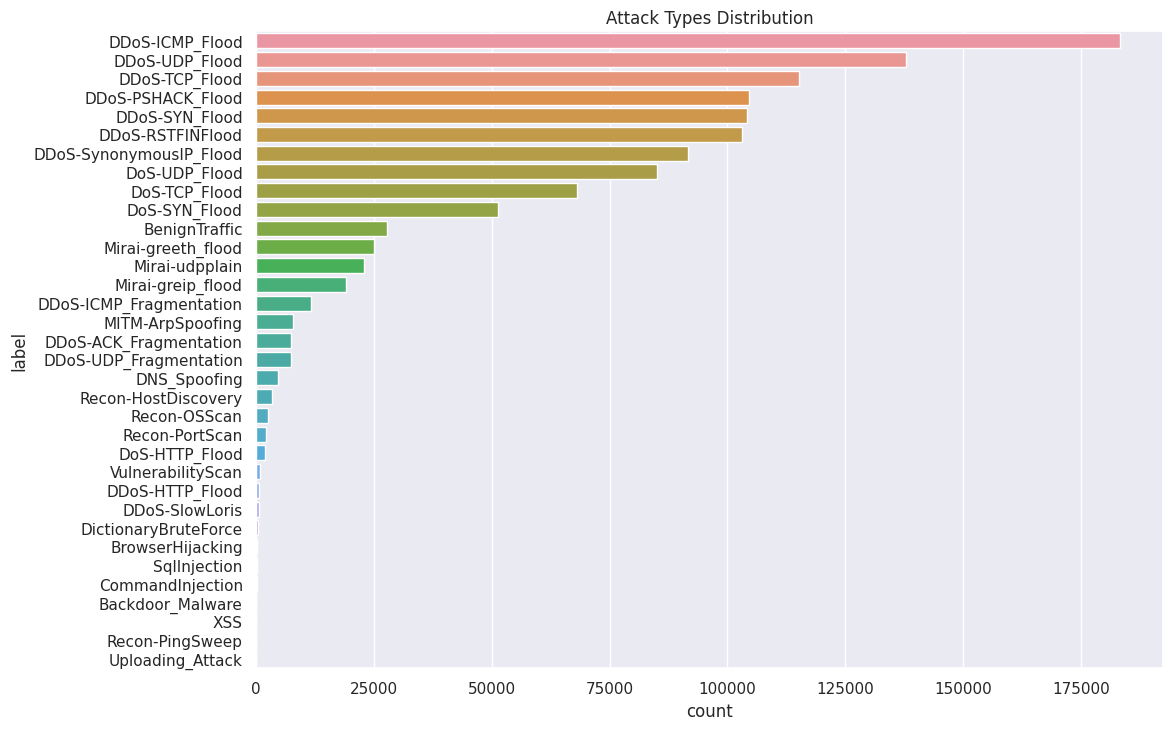

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sort the data frame by counts in descending order
df_sorted = df['label'].value_counts().reset_index()
df_sorted.columns = ['label', 'count']
df_sorted = df_sorted.sort_values(by='count', ascending=False)

# Set the figure size
sns.set(rc={'figure.figsize':(11.7, 8.27)})

# Create the countplot with the sorted data
plt.title('Attack Types Distribution')
plot = sns.countplot(data=df, y='label', order=df_sorted['label'])

# Rotate the y-axis labels for better readability
plot.set_yticklabels(plot.get_yticklabels(), rotation=0)

plt.show()


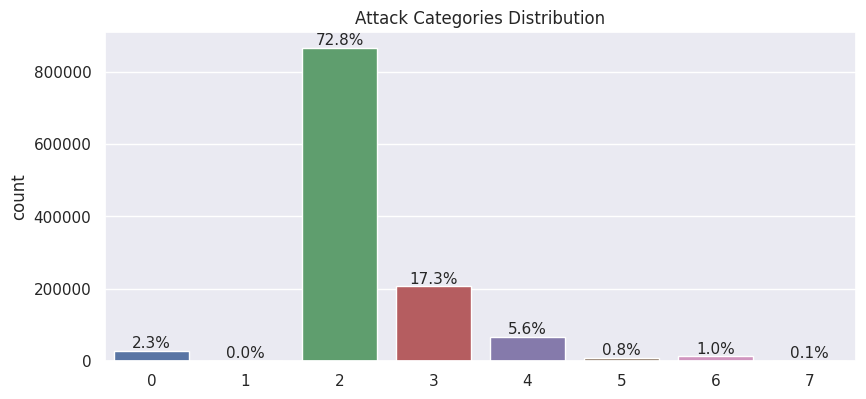

In [9]:
sns.set(rc={'figure.figsize':(9.7,4.27)})
plt.title('Attack Categories Distribution')
ax = sns.countplot(x=label_en_cat)
percentage_above_bar_relative_to_xgroup(ax, len(label_en_cat))

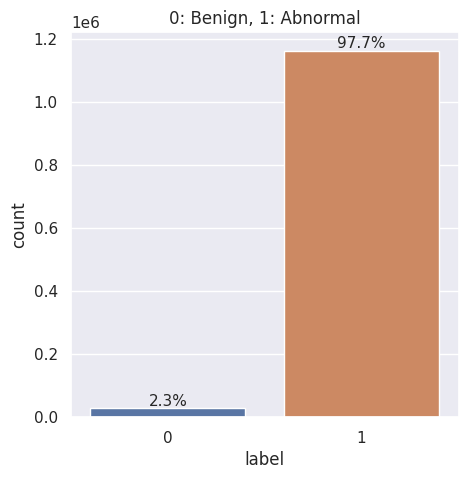

In [10]:
sns.set(rc={'figure.figsize':(5,5)})
plt.title('0: Benign, 1: Abnormal')
ax = sns.countplot(x=label_en_bin)
percentage_above_bar_relative_to_xgroup(ax, len(label_en_bin))

# Data Preprocessing

## 1. Handle Imbalanced Classes

In [15]:
def balanced_dataset(label_en):
    g = df.assign(label = label_en).groupby('label')
    df_balanced = g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True))
    return df_balanced

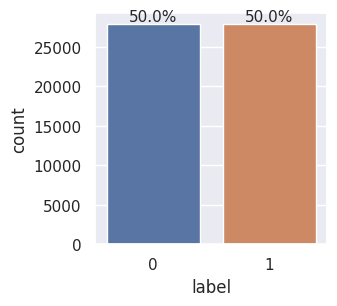

In [12]:
df_ = balanced_dataset(label_en_bin)
sns.set(rc={'figure.figsize':(3,3)})
ax = sns.countplot(x=df_['label'])
percentage_above_bar_relative_to_xgroup(ax, len(df_))

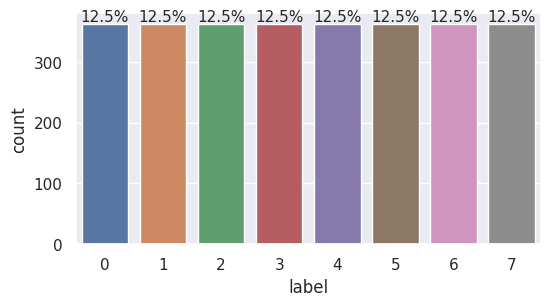

In [13]:
df_ = balanced_dataset(label_en_cat)
sns.set(rc={'figure.figsize':(6,3)})
ax = sns.countplot(x=df_['label'])
percentage_above_bar_relative_to_xgroup(ax, len(df_))

NameError: name 'percentage_above_bar_relative_to_xgroup' is not defined

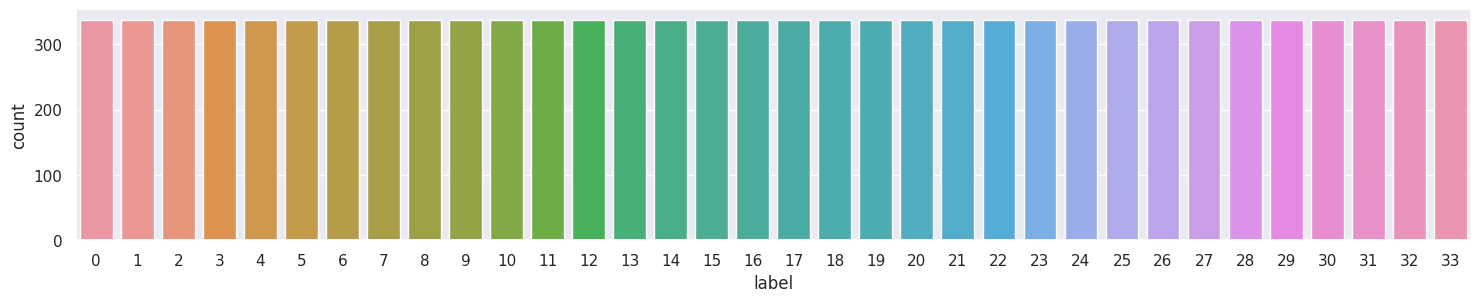

In [26]:
df_ = balanced_dataset(label_en_type)
sns.set(rc={'figure.figsize':(18,3)})
ax = sns.countplot(x=df_['label'])
percentage_above_bar_relative_to_xgroup(ax, len(df_))

## 3. Split Data

- Train: 64% 
- Val: 16% 
- Test: 20%

In [7]:
def xy(df_):
    X = df_.drop('label', axis=1)
    y = df_['label']
    return (X, y)

def split(X,y):
    # Train: 64%, Val: 16%, Test: 20%
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    return (X_train, X_val, X_test, y_train, y_val, y_test)

## 4. Data Scaling
Normalization or Standardization?

In [8]:
def scaling(X_train, X_val, X_test):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    return (X_train, X_val, X_test)

## Feature Selection/Reduction

## Correlation of features

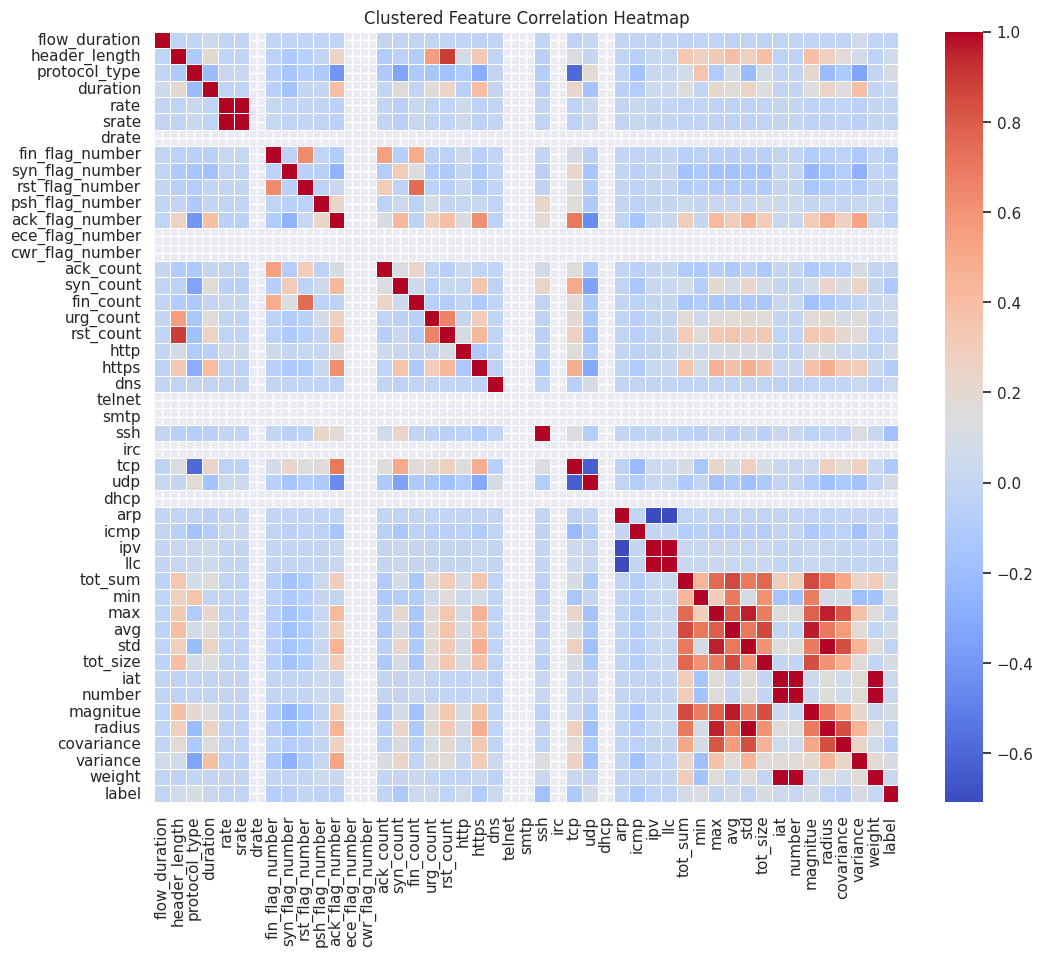

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Call the xy function to get X and y
df_ = balanced_dataset(label_en_cat)
# Calculate the correlation matrix
correlation_matrix = df_.corr()

# Create a clustered heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', linewidths=0.5)
plt.title("Clustered Feature Correlation Heatmap")
plt.show()

In [18]:
for target_variable in (df_.columns):
    # Define the target variable (e.g., 'label' in this example)
    # target_variable = 'header_length'

    # Calculate the correlation between features and the target variable
    correlation_with_target = df_.corr()[target_variable]

    # Set the correlation threshold
    correlation_threshold = 0.7  # Adjust as needed

    # Filter features with correlation above the threshold
    relevant_features = correlation_with_target[correlation_with_target.abs() > correlation_threshold].index
    
    if (len(relevant_features)>1):
        # Print the names of the relevant features
        print("Features with correlation above", correlation_threshold, "to", target_variable, ":")
        print(relevant_features)
        print()

Features with correlation above 0.7 to header_length :
Index(['header_length', 'rst_count'], dtype='object')

Features with correlation above 0.7 to rate :
Index(['rate', 'srate'], dtype='object')

Features with correlation above 0.7 to srate :
Index(['rate', 'srate'], dtype='object')

Features with correlation above 0.7 to rst_flag_number :
Index(['rst_flag_number', 'fin_count'], dtype='object')

Features with correlation above 0.7 to ack_flag_number :
Index(['ack_flag_number', 'tcp'], dtype='object')

Features with correlation above 0.7 to fin_count :
Index(['rst_flag_number', 'fin_count'], dtype='object')

Features with correlation above 0.7 to rst_count :
Index(['header_length', 'rst_count'], dtype='object')

Features with correlation above 0.7 to tcp :
Index(['ack_flag_number', 'tcp'], dtype='object')

Features with correlation above 0.7 to arp :
Index(['arp', 'ipv', 'llc'], dtype='object')

Features with correlation above 0.7 to ipv :
Index(['arp', 'ipv', 'llc'], dtype='object')


## K-best based on chi2 statistical test

In [19]:
def top5_chi2_vis(label_en, problem):
    df_ = balanced_dataset(label_en)
    X_, y_ = xy(df_)

    chi2_scores = SelectKBest(score_func=chi2, k='all')

    X_new = chi2_scores.fit_transform(X_, y_)
    scores = chi2_scores.scores_
    # Replace NaN values with 0
    scores = np.nan_to_num(scores)
    # You can sort the scores and plot them as a bar chart to visualize the feature importance
    sorted_indices = scores.argsort()[::-1]
    sorted_scores = scores[sorted_indices]

    # Plot the scores as a bar chart
    plt.figure(figsize=(10, 1.5))
    sns.barplot(x=sorted_scores[:5], y=X_.columns[sorted_indices[:5]])
    plt.title(f"Chi-squared Feature Scores Top 5 - {problem}")
    plt.show()

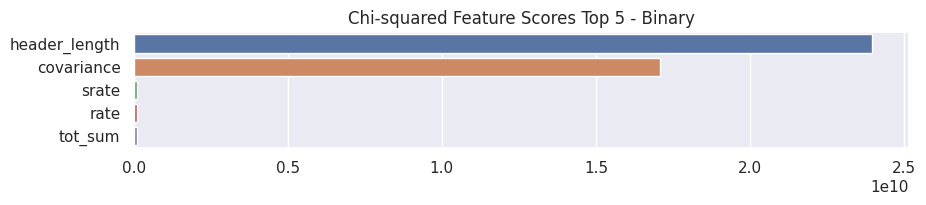

In [20]:
top5_chi2_vis(label_en_bin, 'Binary')

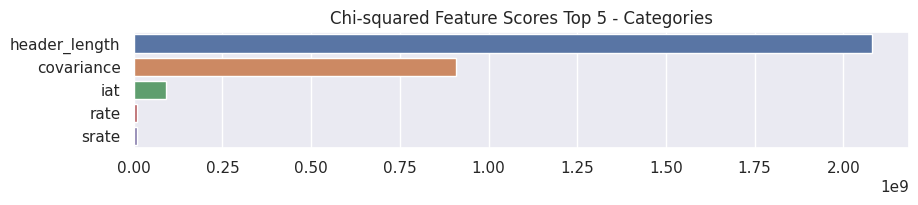

In [21]:
top5_chi2_vis(label_en_cat, 'Categories')

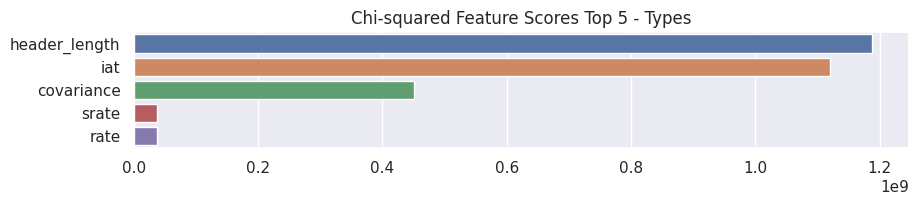

In [22]:
top5_chi2_vis(label_en_type, 'Types')

In [9]:
def reduced_split(X, y, k):
    X_train, X_test, y_train, y_test = train_test_split(SelectKBest(k=k, score_func = chi2).fit_transform(X, y), y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    return (X_train, X_val, X_test, y_train, y_val, y_test)

# Models

In [10]:
def plot_metrics(history):
    mpl.rcParams['figure.figsize'] = (10, 8)
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    metrics = ['loss', 'accuracy', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()

In [11]:
def plot_cm(labels, predictions, threshold=0.5, multiclass=False, target_names=None):
    
    if not multiclass:
        cm = confusion_matrix(labels, predictions > threshold)
        plt.figure(figsize=(5,5))
        sns.heatmap(cm, annot=True, fmt="d")
        plt.title('Confusion matrix @{:.2f}'.format(threshold))
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')

        print(classification_report(labels, predictions > threshold, target_names=target_names))
        print()
        print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
        print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
        print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
        print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
        print('Total Fraudulent Transactions: ', np.sum(cm[1]))
        print()
        
    if multiclass:
        cm = confusion_matrix(labels, predictions)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d")
        plt.title('Confusion matrix for multi classification model')
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        print(classification_report(labels, predictions, target_names=target_names))

In [12]:
def time_response(loaded_model, sample_data):
    sample_data = sample_data[:1000]
    def inference_time():
        predictions = loaded_model.predict(sample_data)  # Replace sample_data with actual data
    inference_time = timeit.timeit(inference_time, number=1)  # Measure time for 1000 predictions
    print(f"Inference time for 1000 predictions: {inference_time} seconds")


## Naive Bayes

In [27]:
df_ = balanced_dataset(label_en_bin)
X, y = xy(df_)
X_train, X_val, X_test, y_train, y_val, y_test = reduced_split(X, y, 28)

In [28]:
# Create a Naive Bayes model
naive_bayes = MultinomialNB()

# Define a grid of hyperparameters to search
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
}

# Create a grid search object
grid_search_nb = GridSearchCV(estimator=naive_bayes, param_grid=param_grid, cv=3, scoring='accuracy')

# Fit the grid search to your data
grid_search_nb.fit(X_train, y_train)

# Get the best hyperparameters
best_params_nb = grid_search_nb.best_params_

# Get the best model
best_model_nb = grid_search_nb.best_estimator_


In [29]:
best_model_nb.fit(X_train, y_train)

MultinomialNB(alpha=0.001)

              precision    recall  f1-score   support

      Benign       0.95      0.76      0.84      5531
   Malicious       0.80      0.96      0.87      5617

    accuracy                           0.86     11148
   macro avg       0.87      0.86      0.86     11148
weighted avg       0.87      0.86      0.86     11148


Legitimate Transactions Detected (True Negatives):  4197
Legitimate Transactions Incorrectly Detected (False Positives):  1334
Fraudulent Transactions Missed (False Negatives):  230
Fraudulent Transactions Detected (True Positives):  5387
Total Fraudulent Transactions:  5617



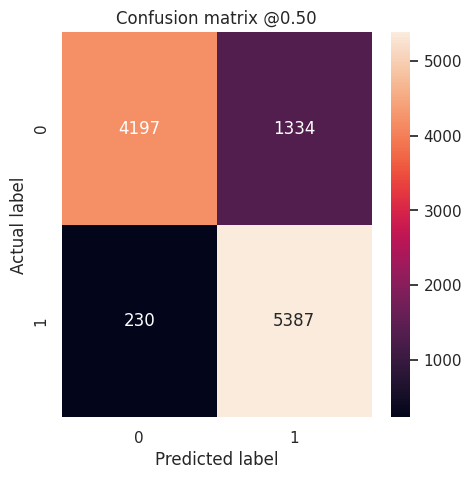

In [30]:
predictions = best_model_nb.predict(X_test)
plot_cm(y_test, predictions, multiclass=False, target_names = ['Benign', 'Malicious'])

In [31]:
time_response(best_model_nb, X_test)

Inference time for 1000 predictions: 0.0005830179999861684 seconds


### 8 Class Classification

In [43]:
df_ = balanced_dataset(label_en_cat)
X, y = xy(df_)
X_train, X_val, X_test, y_train, y_val, y_test = reduced_split(X, y, 28)

In [46]:
# Create a Naive Bayes model
naive_bayes = MultinomialNB()

# Define a grid of hyperparameters to search
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
}

# Create a grid search object
grid_search_nb = GridSearchCV(estimator=naive_bayes, param_grid=param_grid, cv=3, scoring='accuracy')

# Fit the grid search to your data
grid_search_nb.fit(X_train, y_train)

# Get the best hyperparameters
best_params_nb = grid_search_nb.best_params_

# Get the best model
best_model_nb = grid_search_nb.best_estimator_

In [47]:
best_model_nb.fit(X_train, y_train)

MultinomialNB(alpha=0.001)

              precision    recall  f1-score   support

      Benign       0.21      0.20      0.21       699
  BruteForce       0.27      0.11      0.16       704
        DDoS       0.27      0.82      0.40       726
         DoS       0.36      0.31      0.33       746
       Mirai       0.51      0.13      0.21       713
       Recon       0.08      0.01      0.02       715
    Spoofing       0.24      0.50      0.32       715
   Web-based       0.08      0.01      0.02       726

    accuracy                           0.26      5744
   macro avg       0.25      0.26      0.21      5744
weighted avg       0.25      0.26      0.21      5744



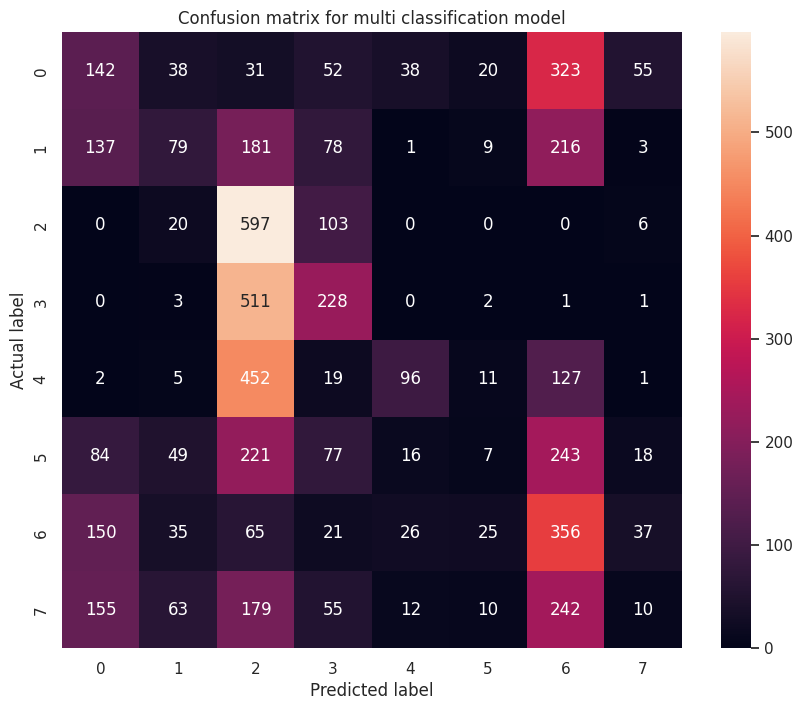

In [49]:
predictions = best_model_nb.predict(X_test)
plot_cm(y_test, predictions, multiclass=True, target_names = le_cat.classes_)

In [50]:
time_response(best_model_nb, X_test)

Inference time for 1000 predictions: 0.0020154410012764856 seconds


## Logistic Regression

In [32]:
df_ = balanced_dataset(label_en_bin)
X, y = xy(df_)
X_train, X_val, X_test, y_train, y_val, y_test = reduced_split(X, y, 28)

In [33]:
# Create a logistic regression model
logistic_regression = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# Define a grid of hyperparameters to search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
}

# Create a grid search object
grid_search_lr = GridSearchCV(estimator=logistic_regression, param_grid=param_grid, cv=3, scoring='accuracy')

# Fit the grid search to your data
grid_search_lr.fit(X_train, y_train)

# Get the best hyperparameters
best_params_lr = grid_search_lr.best_params_

# Get the best model
best_model_lr = grid_search_lr.best_estimator_

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solve

In [34]:
best_model_lr.fit(X_train, y_train)

LogisticRegression(C=0.001, multi_class='multinomial')

              precision    recall  f1-score   support

      Benign       0.94      0.82      0.88      5531
   Malicious       0.85      0.95      0.89      5617

    accuracy                           0.89     11148
   macro avg       0.89      0.89      0.89     11148
weighted avg       0.89      0.89      0.89     11148


Legitimate Transactions Detected (True Negatives):  4559
Legitimate Transactions Incorrectly Detected (False Positives):  972
Fraudulent Transactions Missed (False Negatives):  285
Fraudulent Transactions Detected (True Positives):  5332
Total Fraudulent Transactions:  5617



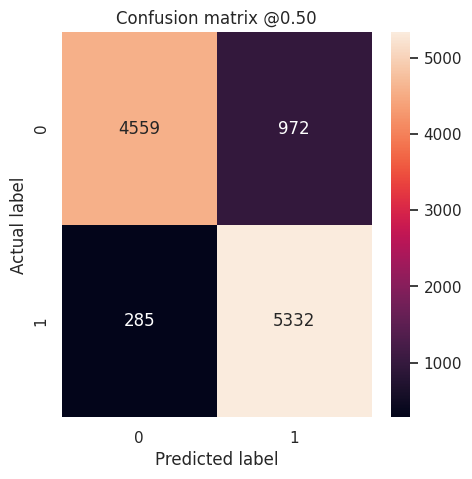

In [35]:
predictions = best_model_lr.predict(X_test)
plot_cm(y_test, predictions, multiclass=False, target_names = ['Benign', 'Malicious'])

In [36]:
time_response(best_model_lr, X_test)

Inference time for 1000 predictions: 0.0011702139999556493 seconds


### 8 Class Classification

In [52]:
df_ = balanced_dataset(label_en_cat)
X, y = xy(df_)
X_train, X_val, X_test, y_train, y_val, y_test = reduced_split(X, y, 28)

In [54]:
# Create a logistic regression model
logistic_regression = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# Define a grid of hyperparameters to search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
}

# Create a grid search object
grid_search_lr = GridSearchCV(estimator=logistic_regression, param_grid=param_grid, cv=3, scoring='accuracy')

# Fit the grid search to your data
grid_search_lr.fit(X_train, y_train)

# Get the best hyperparameters
best_params_lr = grid_search_lr.best_params_

# Get the best model
best_model_lr = grid_search_lr.best_estimator_

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [55]:
best_model_lr.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.001, multi_class='multinomial')

              precision    recall  f1-score   support

      Benign       0.20      0.24      0.22       699
  BruteForce       0.25      0.09      0.13       704
        DDoS       0.25      0.96      0.40       726
         DoS       0.15      0.00      0.01       746
       Mirai       0.51      0.26      0.35       713
       Recon       0.13      0.01      0.02       715
    Spoofing       0.22      0.42      0.29       715
   Web-based       0.06      0.01      0.01       726

    accuracy                           0.25      5744
   macro avg       0.22      0.25      0.18      5744
weighted avg       0.22      0.25      0.18      5744



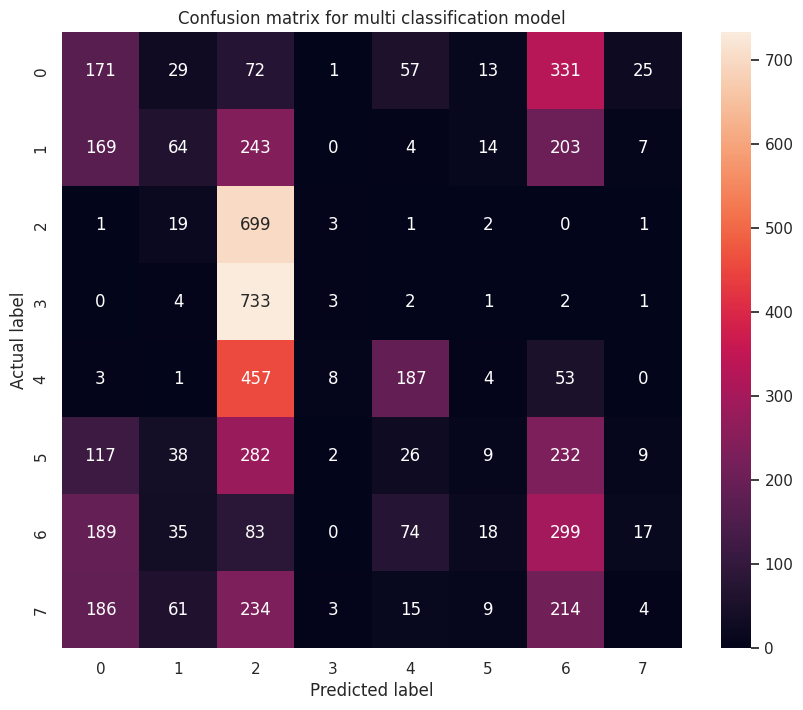

In [63]:
predictions = best_model_lr.predict(X_test)
plot_cm(y_test, predictions, multiclass=True, target_names = le_cat.classes_)

In [64]:
time_response(best_model_lr, X_test)

Inference time for 1000 predictions: 0.0015290489991457434 seconds


## SVM - Support Vector Machine (ML)

### Binary Classification

In [37]:
df_ = balanced_dataset(label_en_bin)
X, y = xy(df_)
X_train, X_val, X_test, y_train, y_val, y_test = reduced_split(X, y, 28)

In [38]:
svm_model = svm.SVC(decision_function_shape='ovo')
svm_model.fit(X_train, y_train)

SVC(decision_function_shape='ovo')

              precision    recall  f1-score   support

      Benign       0.98      1.00      0.99      5531
   Malicious       1.00      0.98      0.99      5617

    accuracy                           0.99     11148
   macro avg       0.99      0.99      0.99     11148
weighted avg       0.99      0.99      0.99     11148


Legitimate Transactions Detected (True Negatives):  5531
Legitimate Transactions Incorrectly Detected (False Positives):  0
Fraudulent Transactions Missed (False Negatives):  120
Fraudulent Transactions Detected (True Positives):  5497
Total Fraudulent Transactions:  5617



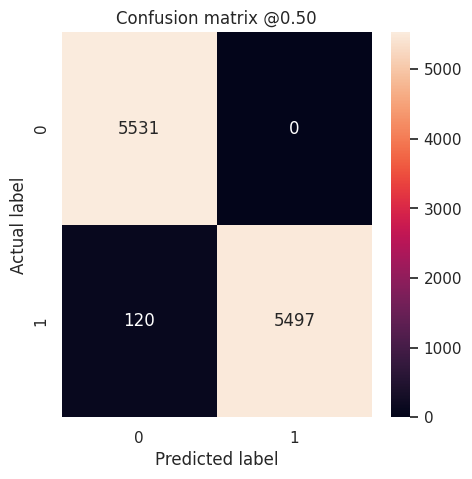

In [39]:
predictions = svm_model.predict(X_test)
plot_cm(y_test, predictions, multiclass=False, target_names=['Benign', 'Malicious'])

In [40]:
time_response(svm_model, X_test[:1000])

Inference time for 1000 predictions: 0.05456951299998991 seconds


### 8 Class Classification

In [41]:
df_ = balanced_dataset(label_en_cat)
X, y = xy(df_)
X_train, X_val, X_test, y_train, y_val, y_test = reduced_split(X, y, 28)

In [42]:
svm_model = svm.SVC(decision_function_shape='ovo', kernel='rbf')
svm_model.fit(X_train, y_train)

SVC(decision_function_shape='ovo')

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      Benign       0.21      0.53      0.30        72
  BruteForce       0.00      0.00      0.00        80
        DDoS       0.30      1.00      0.46        65
         DoS       0.00      0.00      0.00        73
       Mirai       0.00      0.00      0.00        78
       Recon       0.00      0.00      0.00        58
    Spoofing       0.00      0.00      0.00        77
   Web-based       0.20      0.48      0.28        77

    accuracy                           0.24       580
   macro avg       0.09      0.25      0.13       580
weighted avg       0.09      0.24      0.13       580



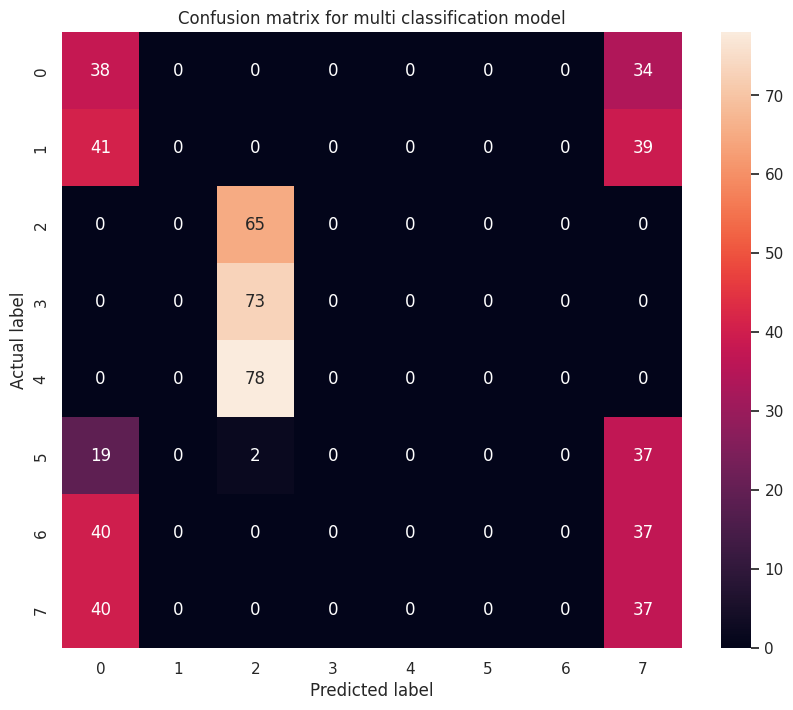

In [43]:
predictions = svm_model.predict(X_test)
plot_cm(y_test, predictions, multiclass=True, target_names = le_cat.classes_)

In [44]:
time_response(svm_model, X_test[:1000])

Inference time for 1000 predictions: 0.0907282480000049 seconds


## XGBoost - ML

In [18]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

xgb_model = xgb.XGBClassifier()

param_space = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.2],
    'reg_lambda': [1, 2, 3],
    'scale_pos_weight': [1, 2, 3]
}

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_space,
    n_iter=50,  # Number of random parameter combinations to try
    cv=3,
    n_jobs=-1,
    scoring='accuracy'
)

### Binary Classification

In [46]:
df_ = balanced_dataset(label_en_bin)
X, y = xy(df_)
X_train, X_val, X_test, y_train, y_val, y_test = reduced_split(X, y, 28)
X_train, X_val, X_test = scaling(X_train, X_val, X_test)

In [47]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           predictor=None, random_state=None, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 0.9],
                                        'gamma': [0, 0.1, 0.2],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 4, 5],
                                        'min_child_weight': [1, 2, 3],
                                        'n_estimators': [100, 200, 300],
                                        'reg_alpha': [0, 0.1, 0.2],
                                        'reg_lambda': [1, 2, 3],
                                        'scale_pos_weight': [1, 2, 3],
                                        'subsample': [0.7, 0.8, 0.9]},
                   scoring='accuracy')

In [48]:
best_params = random_search.best_estimator_.get_params()
print(best_params)

{'objective': 'binary:logistic', 'use_label_encoder': None, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.9, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0.1, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': 2, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 200, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': 0.2, 'reg_lambda': 3, 'sampling_method': None, 'scale_pos_weight': 1, 'subsample': 0.9, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [49]:
# Train with best params
best_xgb_model = xgb.XGBClassifier(**best_params)
best_xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

              precision    recall  f1-score   support

      Benign       0.99      1.00      1.00      5531
   Malicious       1.00      0.99      1.00      5617

    accuracy                           1.00     11148
   macro avg       1.00      1.00      1.00     11148
weighted avg       1.00      1.00      1.00     11148


Legitimate Transactions Detected (True Negatives):  5530
Legitimate Transactions Incorrectly Detected (False Positives):  1
Fraudulent Transactions Missed (False Negatives):  40
Fraudulent Transactions Detected (True Positives):  5577
Total Fraudulent Transactions:  5617



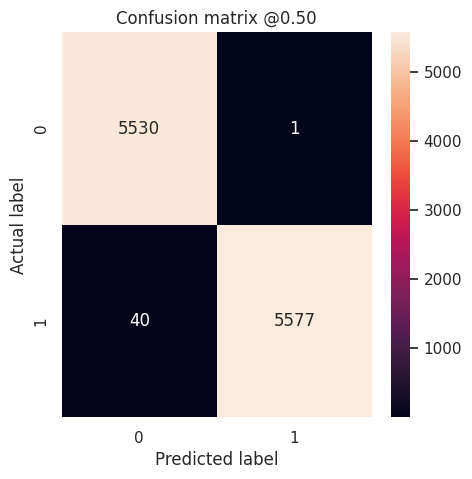

In [50]:
import warnings
warnings.filterwarnings("ignore")
predictions = best_xgb_model.predict(X_test)  # X_test is your test data
plot_cm(y_test, predictions, multiclass=False, target_names = ['Benign', 'Malicious'])

In [51]:
time_response(best_xgb_model, X_test[:1000])

Inference time for 1000 predictions: 0.008060696999905304 seconds


### 8 Class Classification

In [52]:
df_ = balanced_dataset(label_en_cat)
X, y = xy(df_)
X_train, X_val, X_test, y_train, y_val, y_test = reduced_split(X, y, 28)
X_train, X_val, X_test = scaling(X_train, X_val, X_test)

In [53]:
random_search.fit(X_train, y_train)

[07:46:37] WARNING: ../src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.



RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           predictor=None, random_state=None, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 0.9],
                                        'gamma': [0, 0.1, 0.2],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 4, 5],
                                        'min_child_weight': [1, 2, 3],
                                        'n_estimators': [100, 200, 300],
                                        'reg_alpha': [0, 0.1, 0.2],
                                        'reg_lambda': [1, 2, 3],
                                        'scale_pos_weight': [1, 2, 3],
                                        'subsample': [0.7, 0.8, 0.9]},
                   scoring='accuracy')

In [54]:
best_params = random_search.best_estimator_.get_params()
print(best_params)

{'objective': 'multi:softprob', 'use_label_encoder': None, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0.1, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': 2, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 200, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': 0.1, 'reg_lambda': 1, 'sampling_method': None, 'scale_pos_weight': 1, 'subsample': 0.9, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [55]:
# Train with best params
best_xgb_model = xgb.XGBClassifier(**best_params)
best_xgb_model.fit(X_train, y_train)

[07:46:40] WARNING: ../src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

              precision    recall  f1-score   support

      Benign       0.81      0.82      0.81        72
  BruteForce       0.72      0.74      0.73        80
        DDoS       1.00      0.98      0.99        65
         DoS       1.00      1.00      1.00        73
       Mirai       1.00      1.00      1.00        78
       Recon       0.74      0.78      0.76        58
    Spoofing       0.87      0.75      0.81        77
   Web-based       0.74      0.79      0.77        77

    accuracy                           0.86       580
   macro avg       0.86      0.86      0.86       580
weighted avg       0.86      0.86      0.86       580



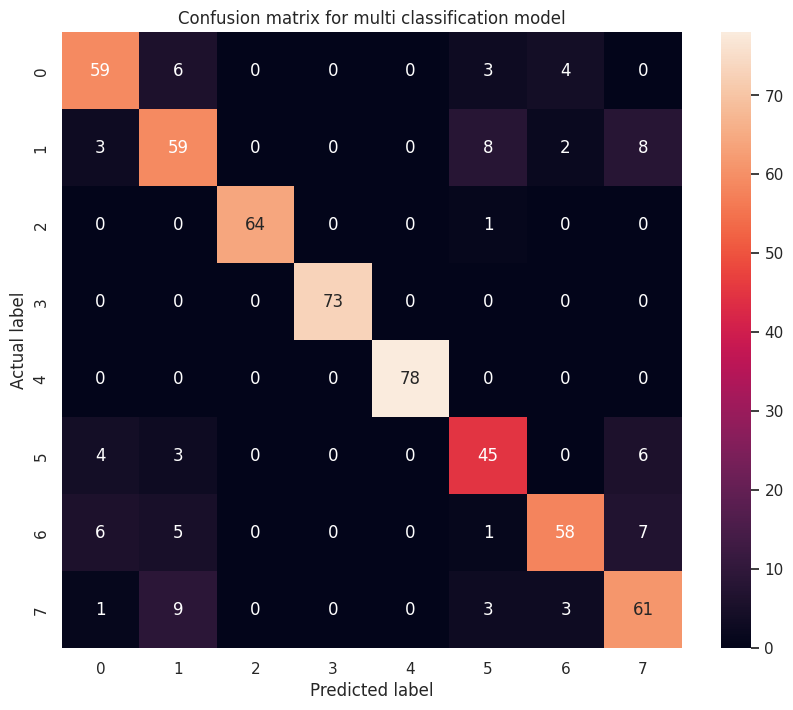

In [56]:
predictions = best_xgb_model.predict(X_test)  # X_test is your test data
plot_cm(y_test, predictions, multiclass=True, target_names = le_cat.classes_)

In [57]:
time_response(best_xgb_model, X_test[:1000])

Inference time for 1000 predictions: 0.015963865000003352 seconds


### 34 Class Classifcation

In [16]:
df_ = balanced_dataset(label_en_type)
X, y = xy(df_)
X_train, X_val, X_test, y_train, y_val, y_test = reduced_split(X, y, 28)
X_train, X_val, X_test = scaling(X_train, X_val, X_test)

In [19]:
random_search.fit(X_train, y_train)

[10:23:07] WARNING: ../src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.



RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           predictor=None, random_state=None, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 0.9],
                                        'gamma': [0, 0.1, 0.2],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 4, 5],
                                        'min_child_weight': [1, 2, 3],
                                        'n_estimators': [100, 200, 300],
                                        'reg_alpha': [0, 0.1, 0.2],
                                        'reg_lambda': [1, 2, 3],
                                        'scale_pos_weight': [1, 2, 3],
                                        'subsample': [0.7, 0.8, 0.9]},
                   scoring='accuracy')

[09:45:14] WARNING: ../src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[09:47:06] WARNING: ../src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[09:48:06] WARNING: ../src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[09:48:59] WARNING: ../src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[09:49:39] WARNING: ../src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[09:50:17] WARNING: ../src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[09:50:41] WARNING: ../src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[09:51:04] WARNING: ../src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[09:52:06] WARNING: ../src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[09:53:41] WARNING: ../src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[09:54:08] WARNING: ../src/learner.cc:767: 
Parameters: { "s

In [22]:
best_params = random_search.best_estimator_.get_params()
print(best_params)

{'objective': 'multi:softprob', 'use_label_encoder': None, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.9, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0.1, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.2, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': 2, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': 0.2, 'reg_lambda': 1, 'sampling_method': None, 'scale_pos_weight': 2, 'subsample': 0.7, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [23]:
# Train with best params
best_xgb_model = xgb.XGBClassifier(**best_params)
best_xgb_model.fit(X_train, y_train)

[10:53:05] WARNING: ../src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

                         precision    recall  f1-score   support

       Backdoor_Malware       0.69      0.60      0.64        72
          BenignTraffic       0.67      0.76      0.71        67
       BrowserHijacking       0.62      0.74      0.68        62
       CommandInjection       0.68      0.61      0.64        71
 DDoS-ACK_Fragmentation       1.00      0.96      0.98        75
        DDoS-HTTP_Flood       0.99      1.00      0.99        69
        DDoS-ICMP_Flood       1.00      0.99      0.99        68
DDoS-ICMP_Fragmentation       1.00      1.00      1.00        81
      DDoS-PSHACK_Flood       1.00      1.00      1.00        63
       DDoS-RSTFINFlood       1.00      1.00      1.00        72
         DDoS-SYN_Flood       1.00      1.00      1.00        86
         DDoS-SlowLoris       1.00      1.00      1.00        68
DDoS-SynonymousIP_Flood       1.00      1.00      1.00        75
         DDoS-TCP_Flood       1.00      1.00      1.00        67
         DDoS-UDP_Flood 

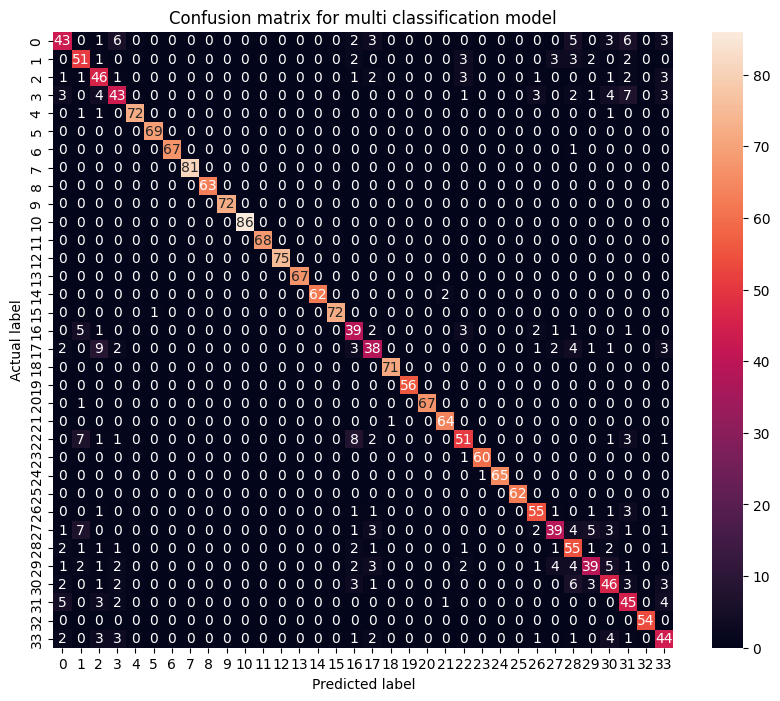

In [24]:
predictions = best_xgb_model.predict(X_test)  # X_test is your test data
plot_cm(y_test, predictions, multiclass=True, target_names = le_type.classes_)

In [42]:
time_response(best_xgb_model, X_test[1000:2000])

Inference time for 1000 predictions: 0.04783536499962793 seconds


## LightGBoost

### Binary Classification

In [65]:
import lightgbm as lgb

param_grid = {
    "num_leaves": [15, 31, 63, 127],
    "learning_rate": [0.05, 0.1, 0.2],
    "n_estimators": [50, 100, 200],
    "feature_fraction": [0.7, 0.8, 0.9],
}
model = lgb.LGBMClassifier()
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=10,  # Number of random combinations to try
    scoring="accuracy",  # Use an appropriate evaluation metric
    cv=3,  # Number of cross-validation folds
    n_jobs=-1,  # Use all available CPU cores
    random_state=42  # Set a random seed for reproducibility
)

In [66]:
df_ = balanced_dataset(label_en_bin)
X, y = xy(df_)
X_train, X_val, X_test, y_train, y_val, y_test = reduced_split(X, y, 28)
X_train, X_val, X_test = scaling(X_train, X_val, X_test)

train_data = lgb.Dataset(data=X_train, label=y_train, free_raw_data=False)
random_search.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7


RandomizedSearchCV(cv=3, estimator=LGBMClassifier(), n_jobs=-1,
                   param_distributions={'feature_fraction': [0.7, 0.8, 0.9],
                                        'learning_rate': [0.05, 0.1, 0.2],
                                        'n_estimators': [50, 100, 200],
                                        'num_leaves': [15, 31, 63, 127]},
                   random_state=42, scoring='accuracy')

In [67]:
best_lgb_params = random_search.best_params_
best_lgb_model = random_search.best_estimator_
# Train the best model on the full training dataset
best_lgb_model.fit(X_train, y_train)

LGBMClassifier(feature_fraction=0.7, learning_rate=0.2, num_leaves=63)

              precision    recall  f1-score   support

      Benign       0.99      1.00      1.00      5531
   Malicious       1.00      0.99      1.00      5617

    accuracy                           1.00     11148
   macro avg       1.00      1.00      1.00     11148
weighted avg       1.00      1.00      1.00     11148


Legitimate Transactions Detected (True Negatives):  5525
Legitimate Transactions Incorrectly Detected (False Positives):  6
Fraudulent Transactions Missed (False Negatives):  47
Fraudulent Transactions Detected (True Positives):  5570
Total Fraudulent Transactions:  5617



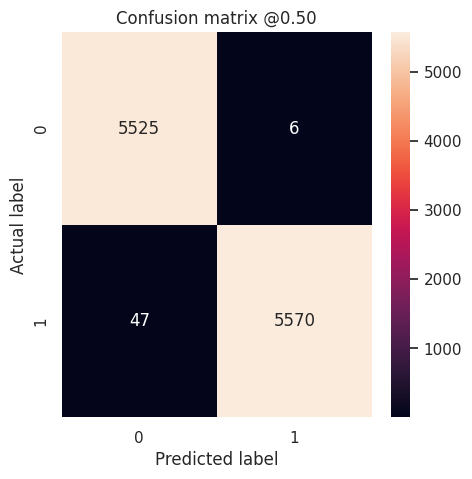

In [68]:
predictions = best_lgb_model.predict(X_test)
plot_cm(y_test, predictions, multiclass=False, target_names = ['Benign', 'Malicious'])

In [69]:
time_response(best_lgb_model, X_test[:1000])

Inference time for 1000 predictions: 0.005504027000142742 seconds


### 8 Class Classification

In [70]:
import lightgbm as lgb

param_grid = {
    "objective": ["multiclass"],
    "num_leaves": [15, 31, 63, 127],
    "learning_rate": [0.05, 0.1, 0.2],
    "n_estimators": [50, 100, 200],
    "feature_fraction": [0.7, 0.8, 0.9],
}
model = lgb.LGBMClassifier()
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=10,  # Number of random combinations to try
    scoring="accuracy",  # Use an appropriate evaluation metric
    cv=3,  # Number of cross-validation folds
    n_jobs=-1,  # Use all available CPU cores
    random_state=42  # Set a random seed for reproducibility
)

In [71]:
df_ = balanced_dataset(label_en_cat)
X, y = xy(df_)
X_train, X_val, X_test, y_train, y_val, y_test = reduced_split(X, y, 28)
X_train, X_val, X_test = scaling(X_train, X_val, X_test)

train_data = lgb.Dataset(data=X_train, label=y_train, free_raw_data=False)
random_search.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGB

RandomizedSearchCV(cv=3, estimator=LGBMClassifier(), n_jobs=-1,
                   param_distributions={'feature_fraction': [0.7, 0.8, 0.9],
                                        'learning_rate': [0.05, 0.1, 0.2],
                                        'n_estimators': [50, 100, 200],
                                        'num_leaves': [15, 31, 63, 127],
                                        'objective': ['multiclass']},
                   random_state=42, scoring='accuracy')

In [72]:
best_lgb_params = random_search.best_params_
best_lgb_model = random_search.best_estimator_
# Train the best model on the full training dataset
best_lgb_model.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGB

LGBMClassifier(feature_fraction=0.7, learning_rate=0.05, n_estimators=200,
               num_leaves=63, objective='multiclass')

              precision    recall  f1-score   support

      Benign       0.83      0.89      0.86        72
  BruteForce       0.79      0.80      0.80        80
        DDoS       1.00      0.97      0.98        65
         DoS       1.00      1.00      1.00        73
       Mirai       1.00      1.00      1.00        78
       Recon       0.73      0.78      0.75        58
    Spoofing       0.84      0.84      0.84        77
   Web-based       0.77      0.69      0.73        77

    accuracy                           0.87       580
   macro avg       0.87      0.87      0.87       580
weighted avg       0.87      0.87      0.87       580



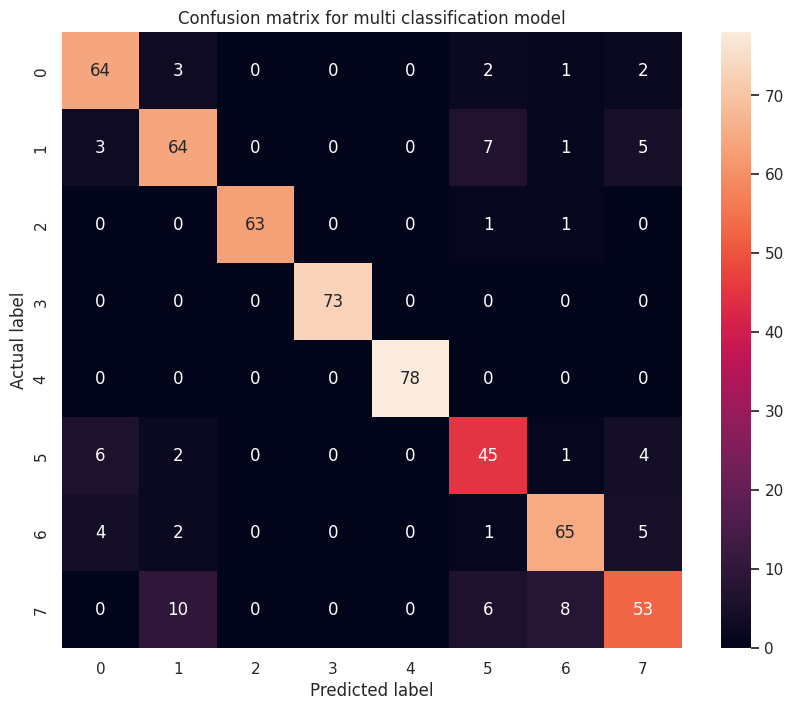

In [74]:
predictions = best_lgb_model.predict(X_test)
plot_cm(y_test, predictions, multiclass=True, target_names = le_cat.classes_)

In [75]:
time_response(best_lgb_model, X_test[:1000])

Inference time for 1000 predictions: 0.04735085699985575 seconds


### 34 Class Classification

In [27]:
import lightgbm as lgb

param_grid = {
    "objective": ["multiclass"],
    "num_leaves": [15, 31, 63, 127],
    "learning_rate": [0.05, 0.1, 0.2],
    "n_estimators": [50, 100, 200],
    "feature_fraction": [0.7, 0.8, 0.9],
}
model = lgb.LGBMClassifier()
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=10,  # Number of random combinations to try
    scoring="accuracy",  # Use an appropriate evaluation metric
    cv=3,  # Number of cross-validation folds
    n_jobs=-1,  # Use all available CPU cores
    random_state=42  # Set a random seed for reproducibility
)

In [28]:
df_ = balanced_dataset(label_en_type)
X, y = xy(df_)
X_train, X_val, X_test, y_train, y_val, y_test = reduced_split(X, y, 28)
X_train, X_val, X_test = scaling(X_train, X_val, X_test)

train_data = lgb.Dataset(data=X_train, label=y_train, free_raw_data=False)
random_search.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


RandomizedSearchCV(cv=3, estimator=LGBMClassifier(), n_jobs=-1,
                   param_distributions={'feature_fraction': [0.7, 0.8, 0.9],
                                        'learning_rate': [0.05, 0.1, 0.2],
                                        'n_estimators': [50, 100, 200],
                                        'num_leaves': [15, 31, 63, 127],
                                        'objective': ['multiclass']},
                   random_state=42, scoring='accuracy')

In [29]:
best_lgb_params = random_search.best_params_
best_lgb_model = random_search.best_estimator_
# Train the best model on the full training dataset
best_lgb_model.fit(X_train, y_train)

LGBMClassifier(feature_fraction=0.9, n_estimators=200, num_leaves=127,
               objective='multiclass')

                         precision    recall  f1-score   support

       Backdoor_Malware       0.65      0.58      0.61        72
          BenignTraffic       0.69      0.75      0.72        67
       BrowserHijacking       0.72      0.71      0.72        62
       CommandInjection       0.68      0.61      0.64        71
 DDoS-ACK_Fragmentation       1.00      0.99      0.99        75
        DDoS-HTTP_Flood       1.00      1.00      1.00        69
        DDoS-ICMP_Flood       0.99      1.00      0.99        68
DDoS-ICMP_Fragmentation       1.00      1.00      1.00        81
      DDoS-PSHACK_Flood       1.00      1.00      1.00        63
       DDoS-RSTFINFlood       1.00      1.00      1.00        72
         DDoS-SYN_Flood       1.00      1.00      1.00        86
         DDoS-SlowLoris       1.00      0.99      0.99        68
DDoS-SynonymousIP_Flood       1.00      1.00      1.00        75
         DDoS-TCP_Flood       1.00      1.00      1.00        67
         DDoS-UDP_Flood 

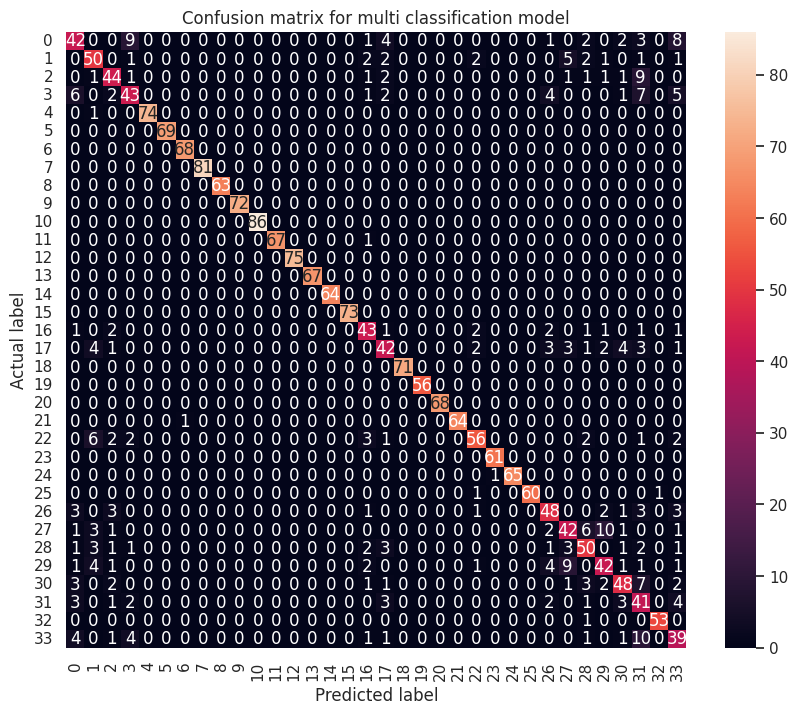

In [30]:
predictions = best_lgb_model.predict(X_test)
plot_cm(y_test, predictions, multiclass=True, target_names = le_type.classes_)

In [31]:
time_response(best_lgb_model, X_test[:1000])

Inference time for 1000 predictions: 0.2281941999999617 seconds
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1

## Simple Neural (ML)

In [65]:
def basic_nn(X_train, y_train, epochs_, output_neurons=1, validation_data=None, output_bias=None, verbose=1):    
    tf.random.set_seed(42)
    
    output_layer = None
    if (output_neurons==1):
        output_layer = tf.keras.layers.Dense(output_neurons, activation='sigmoid', bias_initializer=output_bias)
    else:
        output_layer = tf.keras.layers.Dense(output_neurons, activation='softmax', bias_initializer=output_bias)

    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        output_layer
    ])
    
    loss = None
    if (output_neurons > 1):
            loss=tf.keras.losses.categorical_crossentropy
    else: 
        loss=tf.keras.losses.binary_crossentropy
    
    model.compile(
        loss = loss,
        optimizer=tf.keras.optimizers.Adam(lr=0.03),
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )
    early_stop = EarlyStopping(monitor = 'val_loss', mode='min', verbose = 1, patience = 25)
    model.fit(X_train, y_train, epochs=epochs_, validation_data=validation_data, callbacks=[early_stop], verbose=verbose)
    return model

### 8 Class Classification

In [66]:
df_ = balanced_dataset(label_en_cat)
X, y = xy(df_)
X_train, X_val, X_test, y_train, y_val, y_test = reduced_split(X, y, 28)
X_train, X_val, X_test = scaling(X_train, X_val, X_test)
training1 = basic_nn(X_train, lb_cat.transform(y_train), epochs_=600, output_neurons=8, validation_data=(X_val, lb_cat.transform(y_val)), verbose=0)#, output_bias = initial_bias)


KeyboardInterrupt



In [ ]:
plot_metrics(training1.history)

In [ ]:
predictions = training1.predict(X_test)
plot_cm(y_test, lb_cat.inverse_transform(predictions), multiclass=True, target_names = le_cat.classes_)

## Deep Neural - Hyperparameter Tuning

In [77]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch

def build_nn_model(hp):
    model = keras.Sequential()

    # Number of dense layers and units
    hp_dense_layers = hp.Int('dense_layers', min_value=1, max_value=8, step=1)
    hp_dense_units = hp.Int('dense_units', min_value=64, max_value=512, step=64)

    for _ in range(hp_dense_layers):
        model.add(layers.Dense(units=hp_dense_units, activation='relu'))
        model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(8, activation='softmax'))

    # Learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Compile the model with the specified learning rate
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

def tune_hyperparameters(X_train, y_train, X_val, y_val):
    # Create a tuner
    tuner = RandomSearch(
        build_nn_model,
        objective='val_accuracy',
        max_trials=30,  # Number of hyperparameter combinations to try
        directory='my_tuning_dir',  # Directory to save tuning results
        project_name='nn_tuning'  # Name of the tuning project
    )

    # Define a callback to stop training early if necessary
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

    # Start the search for the best hyperparameters
    tuner.search(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[early_stopping])

    # Get the best hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    # Build and compile the final model with the best hyperparameters
    best_model = build_nn_model(best_hps)

    return tuner, best_model

In [78]:
df_ = balanced_dataset(label_en_cat)
X, y = xy(df_)
X_train, X_val, X_test, y_train, y_val, y_test = reduced_split(X, y, 28)
X_train, X_val, X_test = scaling(X_train, X_val, X_test)
# Reshape X_train to have time_steps=1 for each row
tuner, best_model = tune_hyperparameters(X_train, lb_cat.transform(y_train), X_val, lb_cat.transform(y_val))

Trial 30 Complete [00h 00m 25s]
val_accuracy: 0.5446040034294128

Best val_accuracy So Far: 0.6914708614349365
Total elapsed time: 00h 13m 31s


In [80]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_dense_layers = best_hps.get('dense_layers')
best_dense_units = best_hps.get('dense_units')
best_learning_rate = best_hps.get('learning_rate')
print(f"dense layers:\t {best_dense_layers}")
print(f"dense units:\t {best_dense_units}")
print(f"learning rate:\t {best_learning_rate}")

dense layers:	 3
dense units:	 64
learning rate:	 0.001


### Trying out the best model

In [81]:
def best_nn(X_train, y_train, epochs_, output_neurons=1, validation_data=None, output_bias=None, verbose=1):    
    tf.random.set_seed(42)
    
    output_layer = None
    if (output_neurons==1):
        output_layer = tf.keras.layers.Dense(output_neurons, activation='sigmoid', bias_initializer=output_bias)
    else:
        output_layer = tf.keras.layers.Dense(output_neurons, activation='softmax', bias_initializer=output_bias)

    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='tanh'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        output_layer
    ])
    
    loss = None
    if (output_neurons > 1):
            loss=tf.keras.losses.categorical_crossentropy
    else: 
        loss=tf.keras.losses.binary_crossentropy
    
    model.compile(
        loss = loss,
        optimizer=tf.keras.optimizers.Adam(lr=0.001),
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )
    early_stop = EarlyStopping(monitor = 'val_loss', mode='min', verbose = 1, patience = 25)
    model.fit(X_train, y_train, epochs=epochs_, validation_data=validation_data, callbacks=[early_stop], verbose=verbose)
    return model

### Binary classification

In [82]:
df_ = balanced_dataset(label_en_bin)
X, y = xy(df_)
X_train, X_val, X_test, y_train, y_val, y_test = reduced_split(X, y, 20)
X_train, X_val, X_test = scaling(X_train, X_val, X_test)

In [ ]:
training1 = best_nn(X_train, y_train, epochs_=600, output_neurons=1, validation_data=(X_val, y_val), verbose=0)

In [ ]:
predictions = training1.predict(X_test)
plot_cm(y_test, predictions, multiclass=False, target_names = ['Benign', 'Malicious'])

In [ ]:
time_response(training1, X_test[:1000])

### 8-class

In [ ]:
df_ = balanced_dataset(label_en_cat)
X, y = xy(df_)
X_train, X_val, X_test, y_train, y_val, y_test = reduced_split(X, y, 28)
X_train, X_val, X_test = scaling(X_train, X_val, X_test)

In [ ]:
training2 = best_nn(X_train, lb_cat.transform(y_train), epochs_=600, output_neurons=8, validation_data=(X_val, lb_cat.transform(y_val)), verbose=0)

In [ ]:
predictions = training1.predict(X_test)
plot_cm(y_test, lb_cat.inverse_transform(predictions), multiclass=True, target_names = le_cat.classes_)

In [ ]:
time_response(training2, X_test[:1000])